# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [5]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [6]:
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
data.groupby(['Sex']).mean()['Survived']

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

## In dataset we can see:<br>
There are 577 males and 314 females.<br>
74% of females and only 19% of males survived.


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

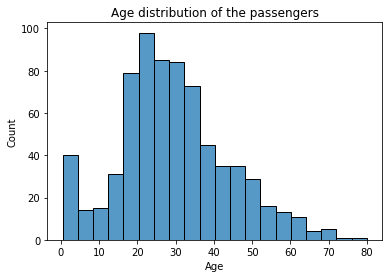

In [9]:
sns.histplot(data['Age'])
plt.title('Age distribution of the passengers')
plt.show()

In [10]:
print(f'Mean for survived: {data[data["Survived"] == 1]["Age"].mean():.2f}')
print(f'Mean for deceased: {data[data["Survived"] == 0]["Age"].mean():.2f}')
print(f'Median for survived: {data[data["Survived"] == 1]["Age"].median():.2f}')
print(f'Median for deceased: {data[data["Survived"] == 0]["Age"].median():.2f}')

Mean for survived: 28.34
Mean for deceased: 30.63
Median for survived: 28.00
Median for deceased: 28.00


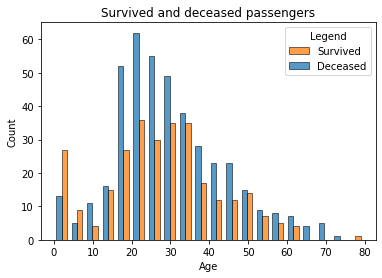

In [11]:
sns.histplot(data, x="Age",hue='Survived', multiple="dodge", legend=False, shrink=.7)
plt.legend(title='Legend', loc='upper right', labels=['Survived', 'Deceased'])
plt.title('Survived and deceased passengers')
plt.show()

We can see that kids have high chance to survive. (35 and 50 y.o. people too)<br>
20-30, 40-45, 65+ y.o. people are 'the most unlucky'.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

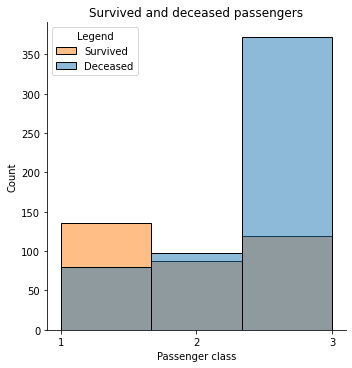

In [12]:
sns.displot(data, x="Pclass",hue='Survived', legend=False, bins=3)
plt.legend(title='Legend', loc='upper left', labels=['Survived', 'Deceased'])
plt.title('Survived and deceased passengers')
plt.xlabel('Passenger class')
plt.xticks([1,2,3])
plt.show()

1st class has bigger chance to survive.<br>
3rd class has worst chance to survive.

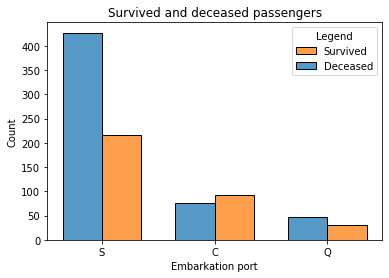

In [13]:
sns.histplot(data[['Embarked', 'Survived']].dropna(), x='Embarked', hue='Survived', multiple="dodge", legend=False, shrink=.7)
plt.legend(title='Legend', loc='upper right', labels=['Survived', 'Deceased'])
plt.title('Survived and deceased passengers')
plt.xlabel('Embarkation port')
plt.show()

Many survived among those who boarded the ship in the port of Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [14]:
round(data.isna().sum() / data.shape[1])

Survived     0.0
Pclass       0.0
Name         0.0
Sex          0.0
Age         16.0
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.0
Cabin       62.0
Embarked     0.0
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can drop NaN values or put the mean value of the column.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [15]:
#да, делал без пайплайна и через дропна, не бейте

In [16]:
data_dropped = data.dropna().copy()
data_dropped['Sex'] = data_dropped['Sex'].replace(['female','male'],[0,1])

In [17]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

In [19]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].mean())
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].mean())
data_test = data_test.drop(columns=['Cabin'])
data_test['Sex'] = data_test['Sex'].replace(['female','male'],[0,1])

In [20]:
print(f"Accuracy of logistic regression model: \
{cross_validate(logReg, data_dropped[['Pclass', 'Sex', 'Age']], data_dropped['Survived'], cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression model: 0.7861861861861861


In [21]:
print(f"Accuracy of K Neighbors Classifier model: \
{cross_validate(knn_model, data_dropped[['Pclass', 'Sex', 'Age']], data_dropped['Survived'], cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of K Neighbors Classifier model: 0.7153153153153153


The accuracy of the KNN model is worst than that of the logistic regression model.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [22]:
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [39]:
#Предположим что информацию по Cabin могли дать лишь выжившие
data['Cabin'] = data['Cabin'].fillna(0).apply(lambda x: 1 if (x != 0) else 0)

In [40]:
def preprocessor(num, categ):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num),
            ('cat', categorical_transformer, categ)])

In [41]:
#но пайплайн все таки пришлось взять
logReg_lvl2= Pipeline([
    ('preprocessor', preprocessor(['Age', 'SibSp', 'Parch', 'Fare'], ['Pclass', 'Sex', 'Embarked', 'Cabin'])),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))), 
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

In [42]:
print(f"Accuracy of logistic regression model: \
{cross_validate(logReg_lvl2, data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']], data['Survived'], cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression model: 0.8204381394764922


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [43]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data_test = data_test.drop(['Name', 'Ticket'], axis=1)
data_test['Cabin'] = data_test['Cabin'].fillna(0).apply(lambda x: 1 if (x != 0) else 0)
predictions = logReg_lvl2.fit(data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']], data['Survived']).predict(data_test)
result = pd.DataFrame({'PassengerId': data_test.index, 'Survived': predictions})
result.to_csv('out.csv', index=False)

## My nickname in Kaggle is Danila Bernath. Tell me plz how to jump over 0.81 if you know :)

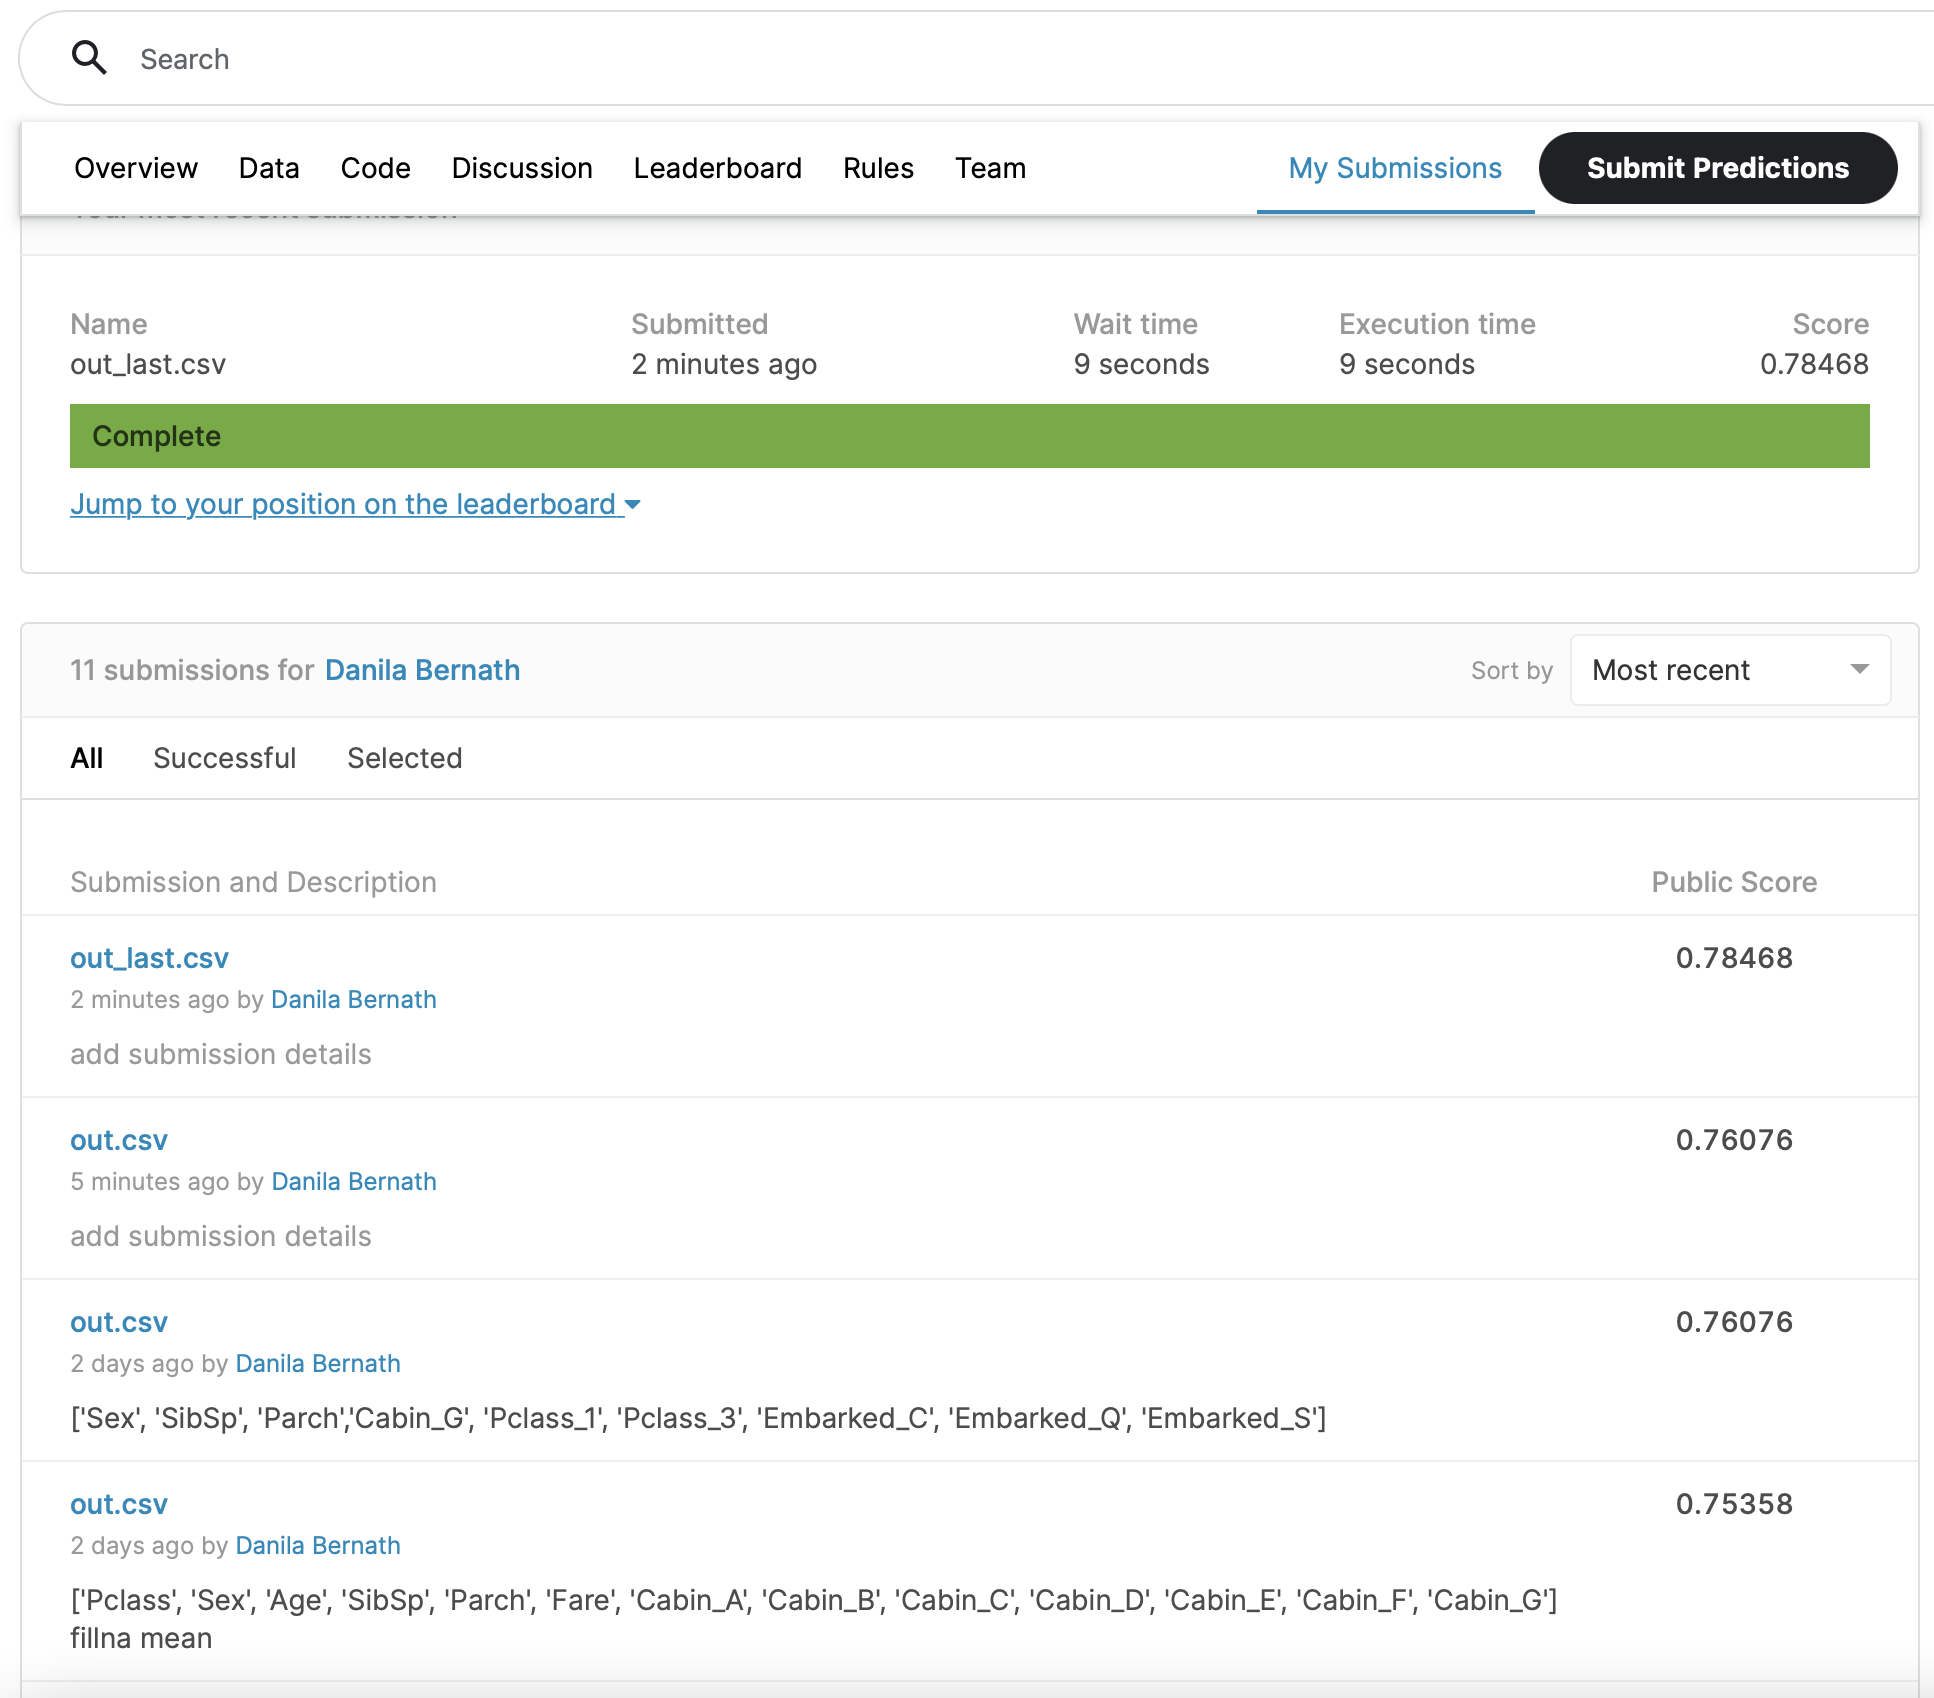

In [29]:
from IPython.display import Image
Image("pic.png")

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [27]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

FileNotFoundError: [Errno 2] No such file or directory: './data/porto/train.csv'

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code